In [1]:
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
import time

import agent

In [2]:
ref_rate = 60
run_time = 30

ref_per  = 1/ref_rate
run_it   = run_time * ref_rate

 Spawning vehicle at location : -8, 25, 0
 Vehicle model : audi etron
 28%|██▊       | 496/1800 [00:13<00:37, 34.75it/s]

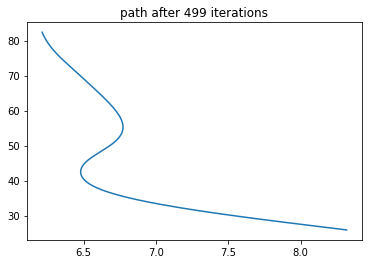

 55%|█████▌    | 998/1800 [00:27<00:22, 36.30it/s]

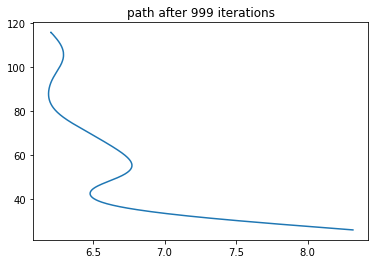

 83%|████████▎ | 1498/1800 [00:40<00:08, 35.06it/s]

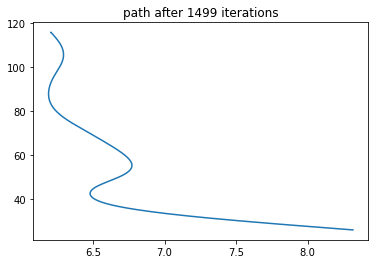

100%|██████████| 1800/1800 [00:49<00:00, 36.56it/s]


In [3]:
a = agent.agent()
a.spawn_vehicle()
a.spawn_imu(ref_per, run_it)
a.spawn_gnss(ref_per, run_it)
a.vehicle.set_autopilot(True)

for i in tqdm(range(run_it)):
    while(i > len(a.gnss_list)):
        time.sleep(0.9 * ref_per)
    if(i % 500 == 499):
        pos = np.asarray([(-x[0][0], x[0][1]) for x in a.rpos_list])
        plt.plot(pos[:,0], pos[:,1])
        plt.title('path after %d iterations'%i)
        plt.show()

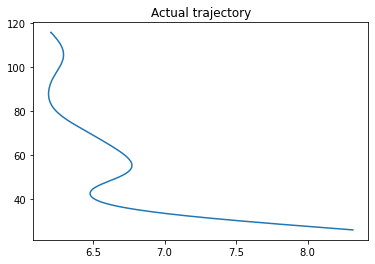

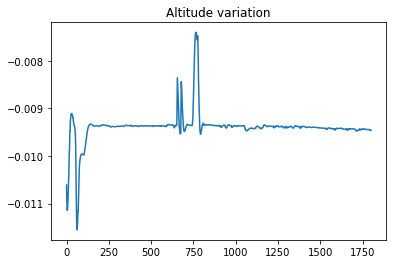

In [4]:
# Since carla uses a left-handed system, we need to visualize by inverting x coordinate
pos = np.asarray([(-x[0][0], x[0][1]) for x in a.rpos_list])
plt.plot(pos[:,0], pos[:,1])
plt.title("Actual trajectory")
plt.show()

plt.plot([x[0][2] for x in a.rpos_list])
plt.title('Altitude variation')
plt.show()

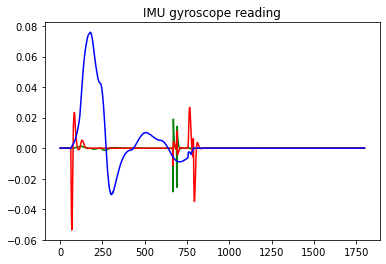


 x axis acceleration average : 39.173
 y axis acceleration average : 21.765


In [5]:
plt.plot([x.gyroscope.x for x in a.imu_list], 'g')
plt.plot([x.gyroscope.y for x in a.imu_list], 'r')
plt.plot([x.gyroscope.z for x in a.imu_list], 'b')
plt.title('IMU gyroscope reading')
plt.show()

print()
print(" x axis acceleration average : %.3f"%np.average(np.abs([x.accelerometer.x for x in a.imu_list])))
print(" y axis acceleration average : %.3f"%np.average(np.abs([x.accelerometer.y for x in a.imu_list])))

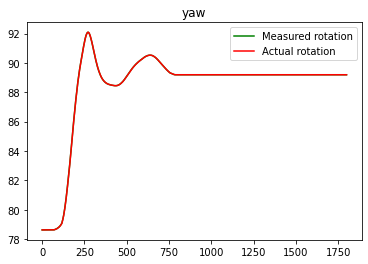

0.004266703477405787


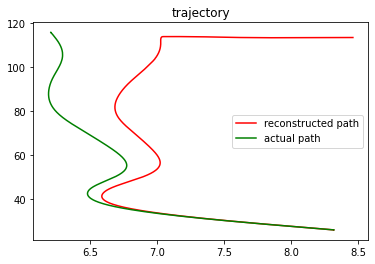

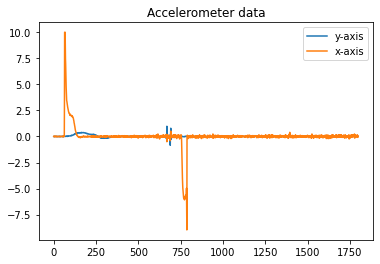

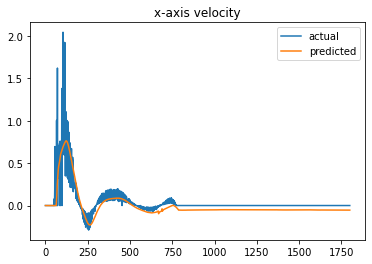

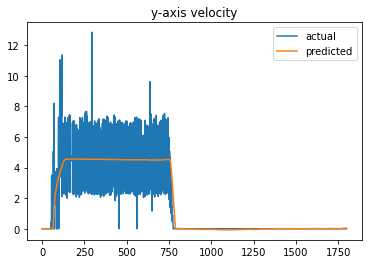

In [17]:
imu_time = [x.timestamp for x in a.imu_list]
imu_vel  = [(0, 0)]
act_vel  = [(0, 0)]
imu_rot  = [a.imu_list[0].transform.rotation.yaw]
imu_pos  = [(a.imu_list[0].transform.location.x, a.imu_list[0].transform.location.y)]
imu_accel_l = []
imu_accel_g = []

for i in range(1, len(a.gnss_list)):
    dt = a.imu_list[i].timestamp - a.imu_list[i-1].timestamp
    gyro = a.imu_list[i].gyroscope
    
    # Update rotation
    yaw = imu_rot[i-1]+(gyro.z*dt*180/np.pi)

    if(yaw > 180):
        yaw = yaw - 360
    elif(yaw < -180):
        yaw = yaw + 360

    imu_rot.append(yaw)

    yaw = a.imu_list[i].transform.rotation.yaw * np.pi / 180

    # Find x and y components of acceleration
    accel_xl = a.imu_list[i].accelerometer.x
    accel_yl = a.imu_list[i].accelerometer.y
    
    if(accel_xl > 10):
        accel_xl = 10
    elif(accel_xl < -10):
        accel_xl = -10
    
    if(accel_yl > 10):
        accel_yl = 10
    elif(accel_yl < -10):
        accel_yl = -10
        
    imu_accel_l.append((accel_xl, accel_yl))

    accel_xg = accel_xl * np.cos(yaw) - accel_yl * np.sin(yaw)
    accel_yg = accel_xl * np.sin(yaw) + accel_yl * np.cos(yaw)
    imu_accel_g.append((accel_xg, accel_yg))

    vel_x = imu_vel[i-1][0] + accel_xg * dt
    vel_y = imu_vel[i-1][1] + accel_yg * dt
    imu_vel.append((vel_x, vel_y))

    act_vel.append(((a.rpos_list[i][0][0]-a.rpos_list[i-1][0][0])/dt, (a.rpos_list[i][0][1]-a.rpos_list[i-1][0][1])/dt))

    pos_x = imu_pos[i-1][0] + vel_x * dt
    pos_y = imu_pos[i-1][1] + vel_y * dt
    imu_pos.append((pos_x, pos_y))

plt.plot(imu_rot, 'g', label="Measured rotation")
plt.plot([x.transform.rotation.yaw for x in a.imu_list], 'r', label="Actual rotation")
plt.legend()
plt.title("yaw")
plt.show()
print(np.average(np.abs(([a.imu_list[i].transform.rotation.yaw - imu_rot[i] for i in range(len(imu_rot))]))))

pos = np.asarray([(x[0], x[1]) for x in imu_pos])
plt.plot(-pos[:,0], pos[:,1], 'r', label="reconstructed path")
pos = np.asarray([(x[0][0], x[0][1]) for x in a.rpos_list])
plt.plot(-pos[:,0], pos[:,1], 'g', label="actual path")
plt.title("trajectory")
plt.legend()
plt.show()

plt.plot([x[1] for x in imu_accel_l], label="y-axis")
plt.plot([x[0] for x in imu_accel_l], label="x-axis")
plt.title("Accelerometer data")
plt.legend()
plt.show()

plt.plot([x[0] for x in act_vel], label="actual")
plt.plot([x[0] for x in imu_vel], label="predicted")
plt.legend()
plt.title("x-axis velocity")
plt.show()

plt.plot([x[1] for x in act_vel], label="actual")
plt.plot([x[1] for x in imu_vel], label="predicted")
plt.legend()
plt.title("y-axis velocity")
plt.show()